# Manual FBS
This notebook couples the 2DOF systems together using the one-way and two-way FBS formulas that were manually derived with basic linear algebra. As a reminder, a graphic of the FBS coupling is shown below, where system A is on the left, system B is on the right, and the coupled system is in the center. 

![Two_DOF_System](./Images/TwoMassSystem.svg)

## Importing Information for the Example
This section imports the necessary packages and FRFs (as SDynPy `TransferFunctionArrays`) from the 2DOF example systems for the computation. These FRFs will be called `system_a_frfs`, `system_b_frfs`, and `coupled_system_frfs` based on the system that they are representative of. 

In [1]:
import numpy as np
import sdynpy as sdpy
import matplotlib.pyplot as plt

In [2]:
system_a_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/system_a_frfs.npz')
system_b_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/system_b_frfs.npz')
coupled_system_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/coupled_system_frfs.npz')

### Organization of the FRF Matrices
It is critical that the we know the organization of the source FRFs to accurately apply FBS manually. As such, the response and reference DOF organization for the system A and system B FRFs will be shown here. 

#### System A FRF Organization

In [3]:
print("The response DOF organization for the system A FRFs is:")
print(system_a_frfs.response_coordinate)

The response DOF organization for the system A FRFs is:
[['1X+' '1X+']
 ['2X+' '2X+']]


In [4]:
print("The reference DOF organization for the system A FRFs is:")
print(system_a_frfs.reference_coordinate)

The reference DOF organization for the system A FRFs is:
[['1X+' '2X+']
 ['1X+' '2X+']]


#### System B FRF Organization

In [5]:
print("The response DOF organization for the system B FRFs is:")
print(system_b_frfs.response_coordinate)

The response DOF organization for the system B FRFs is:
[['3X+' '3X+']
 ['4X+' '4X+']]


In [6]:
print("The reference DOF organization for the system B FRFs is:")
print(system_b_frfs.reference_coordinate)

The reference DOF organization for the system B FRFs is:
[['3X+' '4X+']
 ['3X+' '4X+']]


## Generating the Coupling Force
This section will generate the coupling force matrix as a NumPy ndarray. The coupling force matrix was derived in the course materials and results in the following equation. 

$$
g_3^b=(h_{33}^b+h_{22}^a)^{-1}\begin{Bmatrix}h_{21}^a&h_{22}^a&-h_{33}^b&-h_{34}^b\end{Bmatrix}\begin{Bmatrix}f_1^a\\f_2^a\\f_3^b\\f_4^b\end{Bmatrix}
$$

The resulting vector for the coupling force FRFs is referred to as `coupling_force_frf`. The inverted portion of this equation will be referred to as the kernel. 

```{note}
The `TransferFunctionArrays` are being indexed with preexisting knowledge of how they are organized. Typically, it would be useful to index the data with SDynPy `CoordinateArrays` to ensure that the data is shaped and organized correctly. This will be demonstrated in other examples.
```

```{note}
There are some extra operations in this code (e.g., the use of NumPy newaxis) to make sure that `coupling_force_frf` is appropriately shaped for later operations.
```

In [7]:
kernel = np.linalg.pinv((system_b_frfs[0,0].ordinate + system_a_frfs[1,1].ordinate)[:,np.newaxis,np.newaxis])
coupling_force_frf = kernel@np.concatenate((system_a_frfs[1,0].ordinate[...,np.newaxis], 
                                            system_a_frfs[1,1].ordinate[...,np.newaxis], 
                                           -system_b_frfs[0,0].ordinate[...,np.newaxis], 
                                           -system_b_frfs[0,1].ordinate[...,np.newaxis]),
                                            axis=1)[:,np.newaxis,:]

## One-way FBS
In one-way FBS, we only care about responses on system B due to forces on system A. This form of FBS is particularly useful for TPA problems where we only care about responses on the receiver system (system B in this case) due to forces on the source system (system A in this case). The coupled equation of motion for system B in the one-way FBS framework was derived by zeroing out all the forces acting on the system B FRF equation of motion, then applying the coupling force as an external force to the system B FRFs. This derivation was shown in the course materials and results in the following equation: 

$$
\begin{Bmatrix}\ddot{x}_3^b\\\ddot{x}_4^b\end{Bmatrix}=\begin{Bmatrix}h_{33}^b\\h_{43}^b\end{Bmatrix}(h_{33}^b+h_{22}^a)^{-1}\begin{Bmatrix}h_{21}^a&h_{22}^a\end{Bmatrix}\begin{Bmatrix}f_1^a\\f_2^a\end{Bmatrix}
$$

Where the coupled FRFs can simply be extracted from the equation as:

$$
\begin{bmatrix}h_{31}^{ab}&h_{32}^{ab}\\h_{41}^{ab}&h_{42}^{ab}\end{bmatrix}=\begin{Bmatrix}h_{33}^b\\h_{43}^b\end{Bmatrix}(h_{33}^b+h_{22}^a)^{-1}\begin{Bmatrix}h_{21}^a&h_{22}^a\end{Bmatrix}
$$

These FRFs can be computed with a single line of code with the first column of the `system_b_frfs` and the first two entries of `coupling_force_frf` vector. Note that there are some extra operations in this code to ensure that the variables are shaped so the array multiplication works as expected. Only the first two entries of the `coupling_force_frf` are being used since one-way FBS doesn't use the external force acting on system B.

In [8]:
one_way_fbs_frfs = np.moveaxis(system_b_frfs[:,0].ordinate,-1,0)[...,np.newaxis]@coupling_force_frf[...,:2]

### Comparisons Between One-way FBS and Truth FRFs
A simple `allclose` comparison shows that the FRFs from the one-way FBS coupling are the same as the truth FRFs, where the truth FRFs are indexed with a SDynPy `CoordinateArray` to simplify the bookkeeping (DOFs are referred to as coordinates in SDynPy). This similarity is also shown in a graphical comparison of the FRFs.  

```{note}
The truth FRFs for the coupled system used the node number two to label the coupling DOF rather than three, which would normally be expected since one-way FBS focuses on the response on system B and would typically use the system B node numbers. However, DOFs two and three are the exact same in the coupled system so the labeling difference does not matter in the comparison.
```

In [ ]:
comparison_response_coordinate = sdpy.coordinate_array(string_array=['2X+', '4X+'])
comparison_reference_coordinate = sdpy.coordinate_array(string_array=['1X+', '2X+'])
one_way_truth_frf_dofs = sdpy.coordinate.outer_product(comparison_response_coordinate, 
                                                       comparison_reference_coordinate)

one_way_truth_frfs = np.moveaxis(coupled_system_frfs[one_way_truth_frf_dofs].ordinate, -1, 0)

if np.allclose(one_way_truth_frfs, one_way_fbs_frfs):
    print('The FRFs from the one-way FBS coupling are exactly the same as the FRFs from the truth system')

The FRFs from the one-way FBS coupling are exactly the same as the FRFs from the truth system


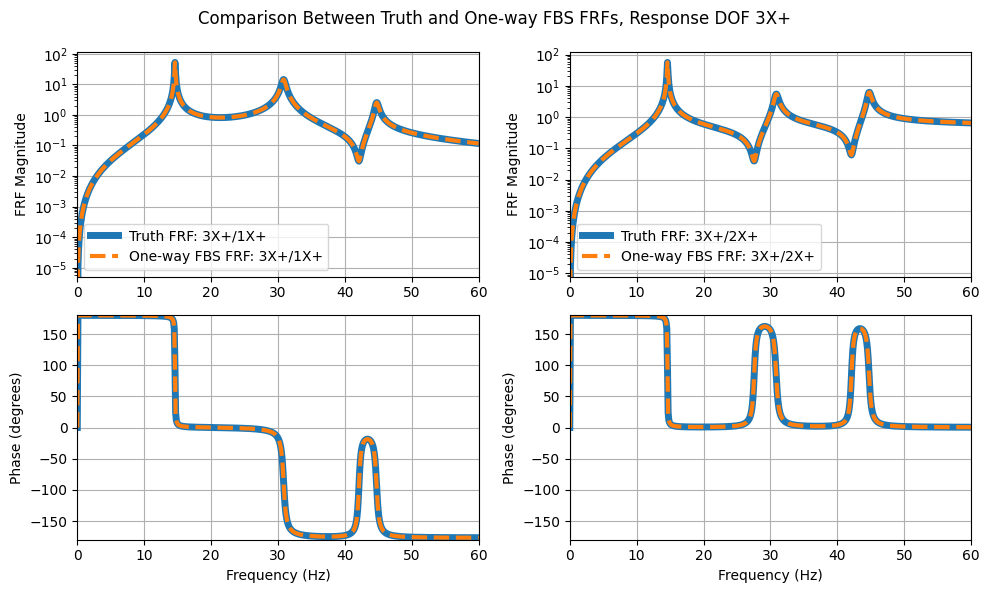

In [ ]:
freq = coupled_system_frfs[0,0].abscissa

fig, ax = plt.subplots(2,2)
ax[0,0].semilogy(freq, np.abs(one_way_truth_frfs[:, 0, 0]), label='Truth FRF: 3X+/1X+', 
                 linewidth=5)
ax[0,0].semilogy(freq, np.abs(one_way_fbs_frfs[:, 0, 0]), label='One-way FBS FRF: 3X+/1X+', 
                 linestyle='--', linewidth=3)
ax[0,0].set_xlim(left=freq[0], right=freq[-1])
ax[0,0].set_ylabel('FRF Magnitude')
ax[0,0].grid()
ax[0,0].legend()

ax[1,0].plot(freq, np.angle(one_way_truth_frfs[:, 0, 0])*180/np.pi, linewidth=5)
ax[1,0].plot(freq, np.angle(one_way_fbs_frfs[:, 0, 0])*180/np.pi, linestyle='--', 
             linewidth=3)
ax[1,0].set_xlim(left=freq[0], right=freq[-1])
ax[1,0].set_ylim(top=180, bottom=-180)
ax[1,0].grid()
ax[1,0].set_ylabel('Phase (degrees)')
ax[1,0].set_xlabel('Frequency (Hz)')

ax[0,1].semilogy(freq, np.abs(one_way_truth_frfs[:, 0, 1]), label='Truth FRF: 3X+/2X+', 
                 linewidth=5)
ax[0,1].semilogy(freq, np.abs(one_way_fbs_frfs[:, 0, 1]), label='One-way FBS FRF: 3X+/2X+', 
                 linestyle='--', linewidth=3)
ax[0,1].set_xlim(left=freq[0], right=freq[-1])
ax[0,1].set_ylabel('FRF Magnitude')
ax[0,1].grid()
ax[0,1].legend()

ax[1,1].plot(freq, np.angle(one_way_truth_frfs[:, 0, 1])*180/np.pi, linewidth=5)
ax[1,1].plot(freq, np.angle(one_way_fbs_frfs[:, 0, 1])*180/np.pi, linestyle='--', 
             linewidth=3)
ax[1,1].set_xlim(left=freq[0], right=freq[-1])
ax[1,1].set_ylim(top=180, bottom=-180)
ax[1,1].grid()
ax[1,1].set_ylabel('Phase (degrees)')
ax[1,1].set_xlabel('Frequency (Hz)')

fig.suptitle('Comparison Between Truth and One-way FBS FRFs, Response DOF 3X+')
fig.set_size_inches(10,6)
fig.set_tight_layout(tight='tight')

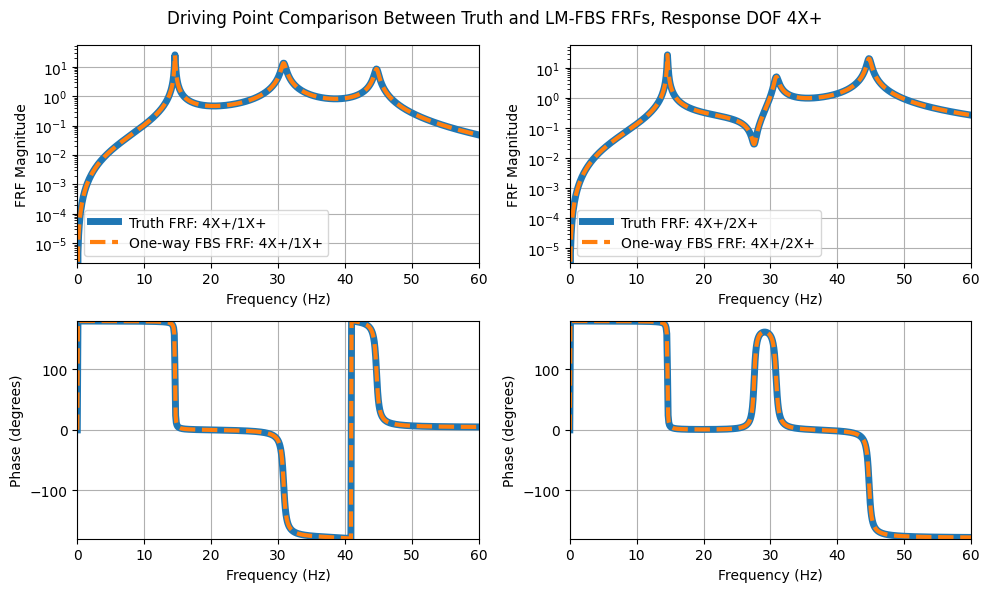

In [ ]:
fig, ax = plt.subplots(2,2)
ax[0,0].semilogy(freq, np.abs(one_way_truth_frfs[:, 1, 0]), label='Truth FRF: 4X+/1X+', 
                 linewidth=5)
ax[0,0].semilogy(freq, np.abs(one_way_fbs_frfs[:, 1, 0]), label='One-way FBS FRF: 4X+/1X+', 
                 linestyle='--', linewidth=3)
ax[0,0].set_xlim(left=freq[0], right=freq[-1])
ax[0,0].set_xlabel('Frequency (Hz)')
ax[0,0].set_ylabel('FRF Magnitude')
ax[0,0].grid()
ax[0,0].legend()

ax[1,0].plot(freq, np.angle(one_way_truth_frfs[:, 1, 0])*180/np.pi, linewidth=5)
ax[1,0].plot(freq, np.angle(one_way_fbs_frfs[:, 1, 0])*180/np.pi, linestyle='--', 
             linewidth=3)
ax[1,0].set_xlim(left=freq[0], right=freq[-1])
ax[1,0].set_ylim(top=180, bottom=-180)
ax[1,0].grid()
ax[1,0].set_ylabel('Phase (degrees)')
ax[1,0].set_xlabel('Frequency (Hz)')

ax[0,1].semilogy(freq, np.abs(one_way_truth_frfs[:, 1, 1]), label='Truth FRF: 4X+/2X+', 
                 linewidth=5)
ax[0,1].semilogy(freq, np.abs(one_way_fbs_frfs[:, 1, 1]), label='One-way FBS FRF: 4X+/2X+', 
                 linestyle='--', linewidth=3)
ax[0,1].set_xlim(left=freq[0], right=freq[-1])
ax[0,1].set_xlabel('Frequency (Hz)')
ax[0,1].set_ylabel('FRF Magnitude')
ax[0,1].grid()
ax[0,1].legend()

ax[1,1].plot(freq, np.angle(one_way_truth_frfs[:, 1, 1])*180/np.pi, linewidth=5)
ax[1,1].plot(freq, np.angle(one_way_fbs_frfs[:, 1, 1])*180/np.pi, linestyle='--', 
             linewidth=3)
ax[1,1].set_xlim(left=freq[0], right=freq[-1])
ax[1,1].set_ylim(top=180, bottom=-180)
ax[1,1].grid()
ax[1,1].set_ylabel('Phase (degrees)')
ax[1,1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and LM-FBS FRFs, Response DOF 4X+')
fig.set_tight_layout(tight='tight')
fig.set_size_inches(10,6)

## Two-way FBS
Two-way FBS is the full substructuring problem, where we compute FRFs for all the DOFs in the coupled system. The coupled FRFs are computed by applying the coupling force to the block diagonal FRFs. This derivation was shown in the course materials and results in the following equation:

$$
\begin{Bmatrix}\ddot{x}_1^a\\\ddot{x}_2^a\\\ddot{x}_3^b\\\ddot{x}_4^b\end{Bmatrix}=\begin{pmatrix}\begin{bmatrix}\begin{matrix}h_{11}^a&h_{12}^a\\h_{21}^a&h_{22}^a\end{matrix}&0\\0&\begin{matrix}h_{33}^b&h_{34}^b\\h_{43}^b&h_{44}^b\end{matrix}\end{bmatrix}+\begin{Bmatrix}-h_{12}^a\\-h_{22}^a\\h_{33}^b\\h_{43}^b\end{Bmatrix}(h_{33}^b+h_{22}^a)^{-1}\begin{Bmatrix}h_{21}^a&h_{22}^a&-h_{33}^b&-h_{34}^b\end{Bmatrix}\end{pmatrix}\begin{Bmatrix}f_1^a\\f_2^a\\f_3^b\\f_4^b\end{Bmatrix}
$$

Where the coupled FRFs can be simply extracted from the equation as:

$$
\begin{bmatrix}H^{ab}\end{bmatrix}=\begin{bmatrix}\begin{matrix}h_{11}^a&h_{12}^a\\h_{21}^a&h_{22}^a\end{matrix}&0\\0&\begin{matrix}h_{33}^b&h_{34}^b\\h_{43}^b&h_{44}^b\end{matrix}\end{bmatrix}+\begin{Bmatrix}-h_{12}^a\\-h_{22}^a\\h_{33}^b\\h_{43}^b\end{Bmatrix}(h_{33}^b+h_{22}^a)^{-1}\begin{Bmatrix}h_{21}^a&h_{22}^a&-h_{33}^b&-h_{34}^b\end{Bmatrix}
$$

### Performing the FBS Coupling
The two-way FBS coupled FRFs are computed with the following process:
1. The block diagonal FRF matrix (the left most entry of the equation) will be generated by creating an appropriately shaped array (named `block_diagonal_frf`) and then filling the correct locations with the system A and B FRFs.
2. The column vector of FRFs (the second entry from the left of the equation, named `column_vector_frf`) is generated by concatenating the appropriate FRFs together.
3. The FBS coupled FRFs are finally computed (named `two_way_fbs_frfs`) using the appropriate operations with `block_diagonal_frf`, `column_vector_frf`, and `coupling_force_frf` (which is made of the right two terms of the above equation).    

In [10]:
block_diagonal_frf = np.zeros((601, 4, 4), dtype=complex)

block_diagonal_frf[:, :2, :2] = np.moveaxis(system_a_frfs.ordinate, -1, 0)
block_diagonal_frf[:, 2:, 2:] = np.moveaxis(system_b_frfs.ordinate, -1, 0)

In [11]:
column_vector_frf = np.concatenate((-system_a_frfs[0,1].ordinate[...,np.newaxis], 
                                    -system_a_frfs[1,1].ordinate[...,np.newaxis], 
                                     system_b_frfs[0,0].ordinate[...,np.newaxis], 
                                     system_b_frfs[1,0].ordinate[...,np.newaxis]), axis=1)[:,:,np.newaxis]

In [12]:
two_way_fbs_frfs = block_diagonal_frf + column_vector_frf@coupling_force_frf

Inspection of the coupled two-way FRF matrix reveals two things:
1. The coupled FRF matrix retains the same shape as the block diagonal FRF matrix since nothing in the method reshapes the FRF matrix.
2. The compatibility condition applies a constraint that forces the FRFs at the coupling DOFs to be the same. This equivalency can be seen in the `allclose` and graphical comparisons below. 

In [13]:
if np.allclose(two_way_fbs_frfs[:, 1, :], two_way_fbs_frfs[:, 2, :]):
    print('All the FRFs with response DOFs two and three are the same')

All the FRFs with response DOFs two and three are the same


In [14]:
if np.allclose(two_way_fbs_frfs[:, :, 1], two_way_fbs_frfs[:, :, 2]):
    print('All the FRFs with reference DOFs two and three are the same')

All the FRFs with reference DOFs two and three are the same


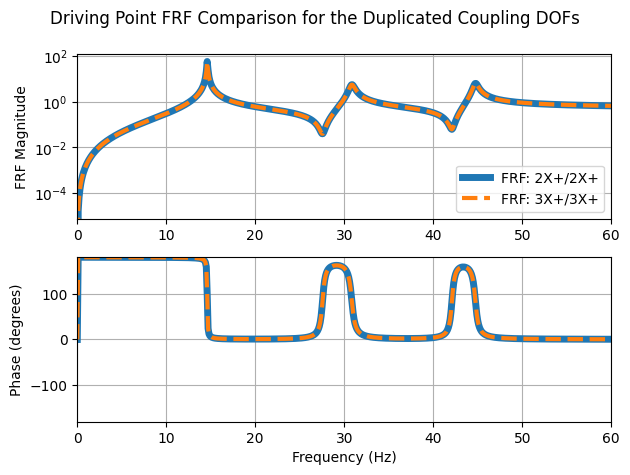

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(two_way_fbs_frfs[:, 1, 1]), label='FRF: 2X+/2X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(two_way_fbs_frfs[:, 2, 2]), label='FRF: 3X+/3X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(two_way_fbs_frfs[:, 1, 1])*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(two_way_fbs_frfs[:, 2, 2])*180/np.pi, linestyle='--', 
           linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point FRF Comparison for the Duplicated Coupling DOFs')
fig.set_tight_layout(tight='tight')

Consequently, the raw output from FBS will have duplicate FRFs at the coupling DOFs. For ease of use, these duplicate FRFs are removed from the coupled FRF matrix to make it the same shape as the truth FRF matrix. 

In [16]:
two_way_fbs_frfs = np.delete(two_way_fbs_frfs, 2, axis=1)
two_way_fbs_frfs = np.delete(two_way_fbs_frfs, 2, axis=2)

### Comparisons Between Two-way FBS and Truth FRFs
A simple `allclose` comparison shows that the FRFs from the two-way FBS coupling are the same as the truth FRFs. This similarity is also shown in a graphical comparison of the driving point FRFs.

In [17]:
two_way_truth_frfs = np.moveaxis(coupled_system_frfs.ordinate,-1,0)
if np.allclose(two_way_fbs_frfs, two_way_truth_frfs):
    print('The FRFs from the two-way FBS coupling are exactly the same as the FRFs from the truth system')

The FRFs from the two-way FBS coupling are exactly the same as the FRFs from the truth system


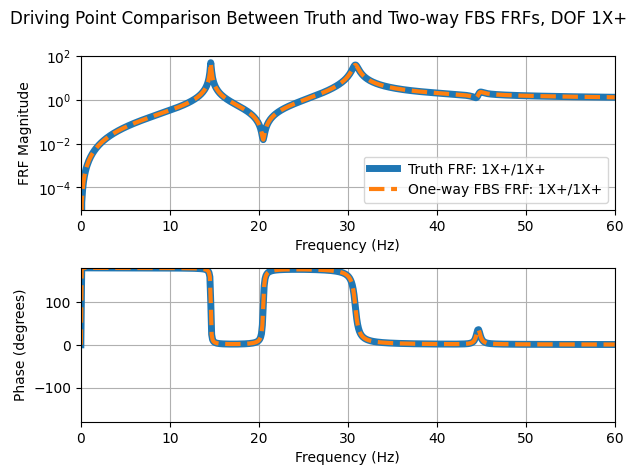

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(two_way_truth_frfs[:, 0, 0]), label='Truth FRF: 1X+/1X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(two_way_fbs_frfs[:, 0, 0]), label='One-way FBS FRF: 1X+/1X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(two_way_truth_frfs[:, 0, 0])*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(two_way_fbs_frfs[:, 0, 0])*180/np.pi, linestyle='--', 
           linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Two-way FBS FRFs, DOF 1X+')
fig.set_tight_layout(tight='tight')

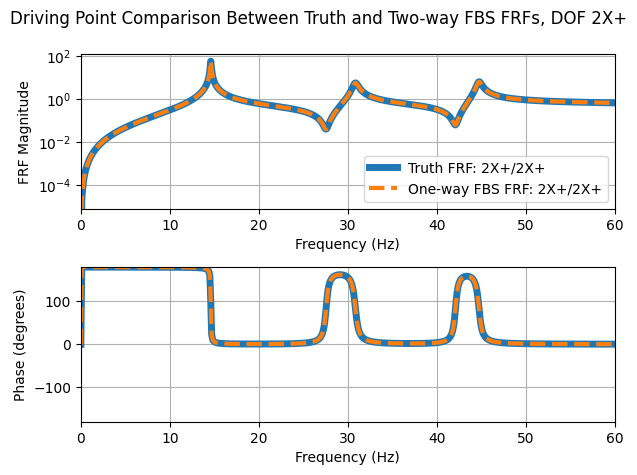

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(two_way_truth_frfs[:, 1, 1]), label='Truth FRF: 2X+/2X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(two_way_fbs_frfs[:, 1, 1]), label='One-way FBS FRF: 2X+/2X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(two_way_truth_frfs[:, 1, 1])*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(two_way_fbs_frfs[:, 1, 1])*180/np.pi, linestyle='--', 
           linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Two-way FBS FRFs, DOF 2X+')
fig.set_tight_layout(tight='tight')

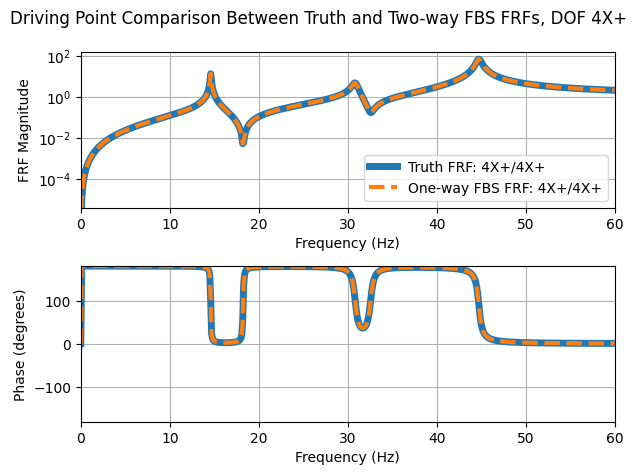

In [ ]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(two_way_truth_frfs[:, 2, 2]), label='Truth FRF: 4X+/4X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(two_way_fbs_frfs[:, 2, 2]), label='One-way FBS FRF: 4X+/4X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(two_way_truth_frfs[:, 2, 2])*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(two_way_fbs_frfs[:, 2, 2])*180/np.pi, linestyle='--', 
           linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and Two-way FBS FRFs, DOF 4X+')
fig.set_tight_layout(tight='tight')

## Conclusions 
This notebook has shown how the FBS coupling can be done with formulas that were manually derived and coded. While the manual method can precisely recreate the truth FRFs, there are several pitfalls:

- The formulas will need to be derived for every application
- It could be difficult to organize the FRFs in the correct manner
- The practitioner must manually build all the matrices and vectors for the FBS computation

These pitfalls (and others) mean that manual FBS coupling is inconvenient and error prone. The LM-FBS method resolves many of these pitfalls, as will be shown in other examples.  